In [411]:
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import math
from collections import defaultdict
np.random.seed(0)

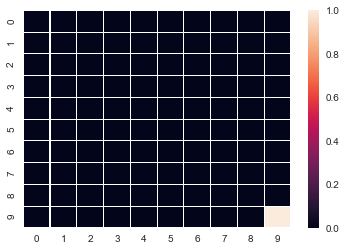

In [66]:
reward1 = np.zeros((10,10))
reward1[9,9] = 1
#cmap = ListedColormap(sns.color_palette("Blues"))
#cmap = sns.cm.rocket_r
sns.heatmap(reward1, linewidths=.1)

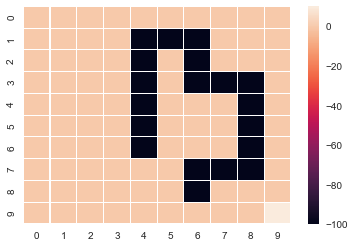

In [67]:
reward2 = np.zeros((10,10))
reward2[[i for i in range(1,7)] , 4] = -100
reward2[1,5] = -100
reward2[[i for i in range(1,4)] , 6] = -100
reward2[[i for i in range(7,9)] , 6] = -100
reward2[3,7] = -100
reward2[7,7] = -100
reward2[[i for i in range(3,8)] , 8] = -100
reward2[9,9] = 10
sns.heatmap(reward2, vmax=10, linewidths=.1)

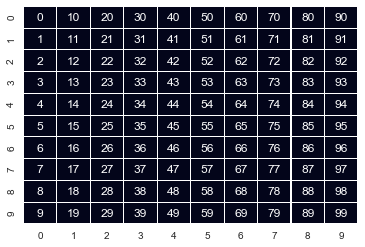

In [481]:
vals = np.arange(0,100)
state_vals = [vals[i:i+10] for i in range(0,100,10)]
state_space = np.array(state_vals).T
state_space
sns.heatmap(state_space, annot=True, fmt="d", linewidths=.1, vmax=0, cbar=False)

In [348]:
a = np.empty(10)
a.fill(-1)
modified_state_space = np.vstack((a, state_space, a))
b = np.empty((12,1))
b.fill(-1)
modified_state_space = np.hstack((b, modified_state_space, b))
modified_state_space

array([[ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
         -1.],
       [ -1.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.,
         -1.],
       [ -1.,   1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91.,
         -1.],
       [ -1.,   2.,  12.,  22.,  32.,  42.,  52.,  62.,  72.,  82.,  92.,
         -1.],
       [ -1.,   3.,  13.,  23.,  33.,  43.,  53.,  63.,  73.,  83.,  93.,
         -1.],
       [ -1.,   4.,  14.,  24.,  34.,  44.,  54.,  64.,  74.,  84.,  94.,
         -1.],
       [ -1.,   5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.,
         -1.],
       [ -1.,   6.,  16.,  26.,  36.,  46.,  56.,  66.,  76.,  86.,  96.,
         -1.],
       [ -1.,   7.,  17.,  27.,  37.,  47.,  57.,  67.,  77.,  87.,  97.,
         -1.],
       [ -1.,   8.,  18.,  28.,  38.,  48.,  58.,  68.,  78.,  88.,  98.,
         -1.],
       [ -1.,   9.,  19.,  29.,  39.,  49.,  59.,  69.,  79.,  89.,  99.,
         -1.],
       [ -1.,  -1.,  

In [103]:
actions = ["R", "L", "U", "D"]
actions

['R', 'L', 'U', 'D']

In [346]:
def neighbors(currentst, nextst):
    if nextst == currentst or nextst == currentst+1 or nextst == currentst-1 or nextst == currentst+10 or nextst == currentst-10:
        return True
    return False

In [347]:
def get_transition_probability(current_state, next_st,  r, c, action, w = 0.1, modified_state_space=modified_state_space):
    n = modified_state_space.shape[1]
    if action == "R":
        next_state = modified_state_space[r, c+1]
    if action =="L":
        next_state = modified_state_space[r, c-1]
    if action == "U":
        next_state = modified_state_space[r-1, c]
    if action == "D":
        next_state = modified_state_space[r+1, c]
   
    if next_st == -1 or not neighbors(current_state, next_st):
        # transition not possible
        return 0  
    if next_state == -1 and (current_state ==0 or current_state==9 or current_state==90 or current_state==99):
        # corner states action moving off grid 
        if next_st == current_state:
            return (1-w+w/4+w/4)
        else:
            return (w/4)
    if next_state != -1 and (current_state ==0 or current_state==9 or current_state==90 or current_state==99):
        # corner states action moving on grid 
        if next_st == current_state:
            return (w/4+w/4)
        if next_state == next_st:
            return (1-w+w/4)
        else:
            return (w/4)
        
    if r == 1 or r == n-2 or c == 1 or c == n-2:
        # edge states
        if next_state == -1:
            # edge states action moving off grid
            if next_st == current_state:
                return (1-w+w/4)
            else:
                return (w/4)
        else:
            # edge states action moving on grid
            if next_st == next_state:
                return (1-w+w/4)
            else:
                return (w/4)
    else:
        # non boundary states
        if next_state == next_st:
            return (1-w+w/4)
        if neighbors(current_state, next_st):
            return (w/4)
        else:
            # action not possible
            return (0)
        

In [351]:
get_transition_probability(44, 34,  5, 5, "U", w = 0.1)

0.025

In [428]:
def get_estimation(s, reward, value, discount, modified_state_space=modified_state_space, action_set=actions):
    neighbor_states = [(s[0],s[1]), (s[0]+1,s[1]), (s[0]-1,s[1]), (s[0],s[1]+1), (s[0], s[1]-1)]
    probs = defaultdict(list)
    action_map = {ac:actions.index(ac) for ac in action_set}
    estimations = np.zeros((len(action_set), len(neighbor_states)))
    
    for ac in action_set:
        for ns in neighbor_states:
            probs[ac].append(get_transition_probability(modified_state_space[s], modified_state_space[ns],  s[0], s[1], ac))
     
    for ac in action_set:
        for n in range(len(neighbor_states)):
            estimations[action_map[ac], n] = probs[ac][n] * (reward[(s[0]-1, s[1]-1)] + discount*value[(s[0]-1, s[1]-1)])
    
    return estimations

In [482]:
def value_iteration(reward, state_space, action_set, w, discount, epsilon):
    n = len(state_space)
    states = [(i,j) for i in range(n) for j in range(n)]
    optimal_value = np.zeros((n,n))
    optimal_policy = np.zeros((n,n))
    delta = math.inf
    while delta > 0.01:
        delta = 0
        for s in states:
            v = optimal_value[s]
            action_estimations = get_estimation((s[0]+1,s[1]+1), reward, optimal_value, discount)
            optimal_value[s] = max(np.sum(action_estimations, axis=1))
            optimal_policy[s] = np.argmax(np.sum(action_estimations, axis=1))
            delta = max(delta, abs(v - optimal_value[s]))

    return optimal_value, optimal_policy

In [483]:
value1, policy1 = value_iteration(reward1, state_space, actions, 0.1, 0.8, 0.01)
print(value1)

[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0

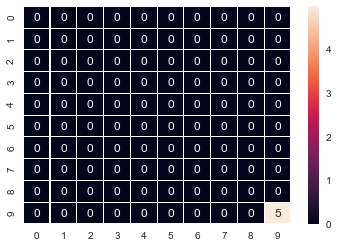

In [484]:
sns.heatmap(value1, annot=True, linewidths=.1)

In [485]:
print(policy1)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [448]:
value2, policy2 = value_iteration(reward2, state_space, actions, 0.1, 0.8, 0.01)
print(value2)

[[   0.            0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.         -499.96597176
  -499.96597176 -499.96597176    0.            0.            0.        ]
 [   0.            0.            0.            0.         -499.96597176
     0.         -499.96597176    0.            0.            0.        ]
 [   0.            0.            0.            0.         -499.96597176
     0.         -499.96597176 -499.96597176 -499.96597176    0.        ]
 [   0.            0.            0.            0.         -499.96597176
     0.            0.            0.         -499.96597176    0.        ]
 [   0.            0.            0.            0.         -499.96597176
     0.            0.            0.         -499.96597176    0.        ]
 [   0.            0.            0.            0.         -499.96597176
     0.            0.            0.         -499.96597176    0.   

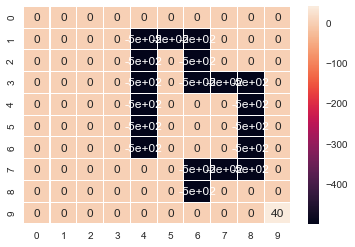

In [449]:
sns.heatmap(value2, annot=True, linewidths=.1)

In [450]:
print(policy2)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
